### Import packages

In [1]:
    include("fwmodule.jl")    
    using Pkg
    using .FWmodule
    using DifferentialEquations
    using DiffEqFlux
    using OrdinaryDiffEq
    using Lux
    using Optim
    using GalacticOptim
    using Optimization
    using ComponentArrays
    using DiffEqSensitivity
    using Flux.Losses: mae, mse, logitcrossentropy
    using LinearAlgebra
    using DelimitedFiles
    using Random
    using Statistics
    using Plots
    gr()
    using Optimization, OptimizationOptimisers, OptimizationOptimJL
    using SBMLToolkit, ModelingToolkit
    using Catalyst, Latexify
    

    Updating registry at `C:\Users\marce\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes t

### Import SBML model

In [2]:
filepath = "model.sbml"
lvl = 2
version = 4
mdl = FWmodule.import_sbml(filepath, lvl, version)

SBML.Model with 2 reactions, 7 species, and 6 parameters.

In [3]:
# Define Reactions system, ODE system, Reactions vector, Species vector and ODE Functions
rs, odesys, reactionsvector, speciesvector, ode_func2 = FWmodule.define_model(mdl);
speciesvector

┌ Warning: SBMLToolkit currently fires events regardless of uppass or downpass trigger.
└ @ SBMLToolkit C:\Users\marce\.julia\packages\SBMLToolkit\L2qXg\src\events.jl:28


7-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 Species0(t)
 Species1(t)
 Species6(t)
 Species3(t)
 Species2(t)
 Species7(t)
 Species4(t)

In [4]:
# Setting the initial concentrations
u0 = zeros(7)
u0[1] = 10.0;      # Species0
u0[2] = 5.0;       # Species1 
u0[3] = 8.0;       # Species6
u0[4] = 0.0;       # Species3
u0[5] = 0.0;       # Species2
u0[6] = 0.0;       # Species7
u0[7] = 0.0;      # Species4

# Selected Species
selected_species = [1, 2, 3, 4, 5, 6, 7];

In [5]:
len_param = length(reactionparams(rs))
paramsvector = reactionparams(rs)[1:len_param-1]

6-element Vector{Sym{Real, Base.ImmutableDict{DataType, Any}}}:
 Reaction0_Km
 Reaction1_A
 Reaction1_Km
 Reaction0_A
 Reaction0_Vmax
 Reaction1_Vmax

In [6]:
# Define Params (based on the SBML file information and the order from the last block)
# Obs: value '0.0' cause posterior errors if in any parameter variable, substitute it with 0.1 if necessary
#                       0_km,   1_A, 1_km,   0_A,       0_Vmax,      1_Vmax
model_param = Float32.([0.0007, 0.1, 0.0002, 0.1, 0.0000002233333, 0.0000005]);

In [7]:
# Generating the time series with a simulation 
tspan = (0.0f0, 25.0f0); method = Rosenbrock23();
abstol= 1e-12; reltol=1e-6; saveat = 0.1;
X, t = FWmodule.gen_timeseries(tspan, odesys, u0, model_param, method, abstol, reltol, saveat);

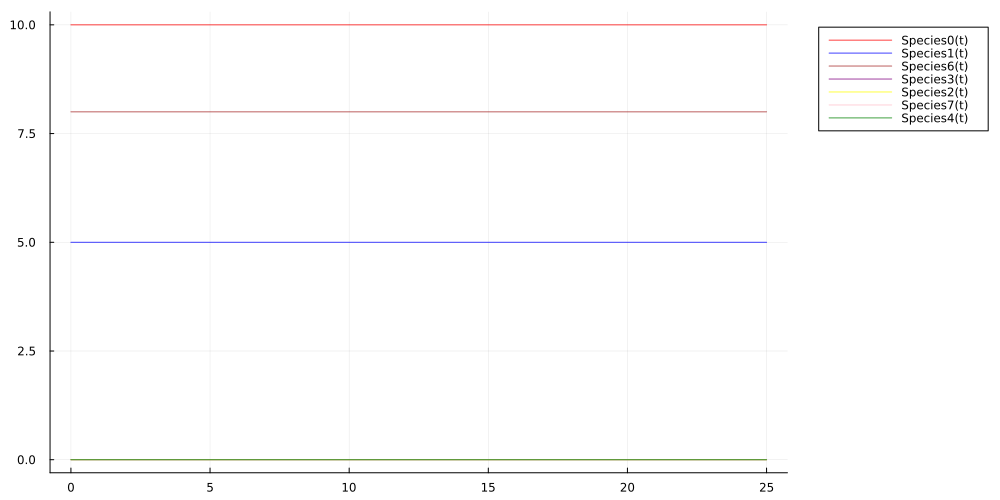

In [8]:
# Plotting
default(size = (1000, 500))
plot(
    t, X', alpha=0.75, 
    legend=:outertopright,
    labels=permutedims(speciesvector),
    ls=permutedims([:solid,:solid,:solid,:solid,:solid,:solid,:solid]),
    color=permutedims([:red, :blue, :brown, :purple, :yellow, :pink, :green])
)

### Import the cutout model

In [9]:
# Import cutout model
mdl2 = FWmodule.import_sbml("cutmodel.sbml", 2, 4)

SBML.Model with 1 reactions, 7 species, and 3 parameters.

In [10]:
# Generate reaction 
rs2, odesys2, reactionsvector2, speciesvector2, ode_func2 = FWmodule.define_model(mdl2);
speciesvector2

┌ Warning: SBMLToolkit currently fires events regardless of uppass or downpass trigger.
└ @ SBMLToolkit C:\Users\marce\.julia\packages\SBMLToolkit\L2qXg\src\events.jl:28


7-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 Species0(t)
 Species1(t)
 Species6(t)
 Species3(t)
 Species2(t)
 Species7(t)
 Species4(t)

In [11]:
u0_2 = zeros(7)
u0_2[1] = 10.0;      # Species0
u0_2[2] = 5.0;       # Species1 
u0_2[3] = 8.0;       # Species6
u0_2[4] = 0.0;       # Species3
u0_2[5] = 0.0;       # Species2
u0_2[6] = 0.0;       # Species7
u0_2[7] = 0.0;      # Species4

selected_species2 = [1, 2, 3, 4, 5, 6, 7];

In [12]:
len_param2 = length(reactionparams(rs2))
paramsvector2 = reactionparams(rs2)[1:len_param2-1]

3-element Vector{Sym{Real, Base.ImmutableDict{DataType, Any}}}:
 Reaction1_A
 Reaction1_Km
 Reaction1_Vmax

In [13]:
# Params
## Obs: value '0.0' cause posterior errors if in any parameter variable, substitute it with 0.1 if necessary
#                        1_A,  1_Km,    1_Vmax
model_param2 = Float32.([0.1, 0.0002, 0.0000005]);

In [14]:
# Generating the time series with a simulation
tspan2 = (0.0f0, 25.0f0);
method2 = Rosenbrock23();
abstol2= 1e-12; reltol2=1e-6; saveat2 = 0.1;
X_2, t_2 = FWmodule.gen_timeseries(tspan2, odesys2, u0_2, model_param2, method2, abstol2, reltol2, saveat2);

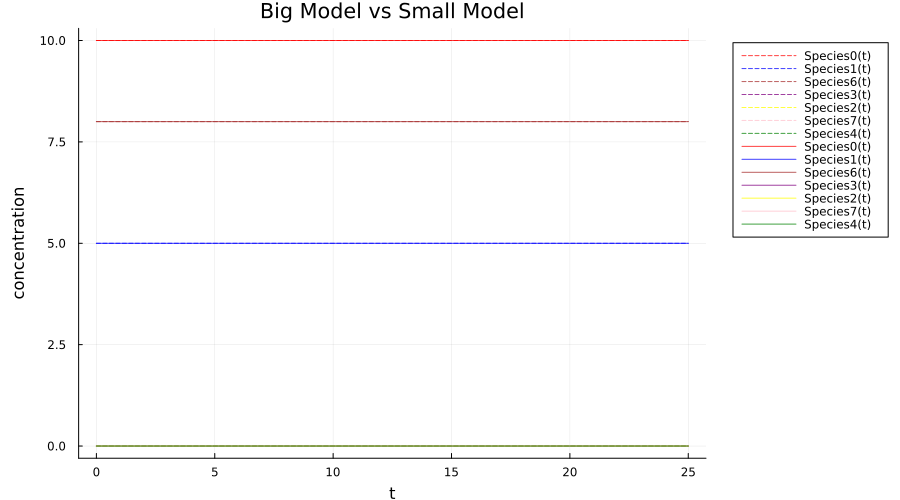

In [15]:
# Plotting
default(size = (900, 500));
plot(
    t, 
    X'[:, selected_species],
    alpha=0.75, legend=:outertopright,
    labels=permutedims(speciesvector),
    color=permutedims([:red, :blue, :brown, :purple, :yellow, :pink, :green]),
    ls=:dash,
)
xlabel!("t")
ylabel!("concentration")
plot!(
    t_2, 
    X_2'[:, selected_species2],
    title="Big Model vs Small Model",
    alpha=0.75, legend=:outertopright,
    labels=permutedims(speciesvector2),
    color=permutedims([:red, :blue, :brown, :purple, :yellow, :pink, :green]),
    left_margin=5Plots.mm
)

### Turning ODE's into a system of UDE's

In [16]:
# Defining the neural network characteristics
rng = Random.default_rng()

U = Lux.Chain(
    Lux.Dense(7, 7, Lux.sigmoid),   
    Lux.Dense(7, 7, Lux.sigmoid),
    Lux.Dense(7, 7, Lux.sigmoid),
    Lux.Dense(7, 7)                 
)

nn_p, nn_st = Lux.setup(rng, U);

# Converting to UDE's
nn_dynamics!(du, u, p, t) = FWmodule.ude_dynamics!(du, u, model_param2, p, nn_st, t_2, ode_func2, U)

nn_dynamics! (generic function with 1 method)

### Training the model

In [17]:
# Generating predict and loss functions parameters
prob_nn = ODEProblem(nn_dynamics!, u0_2, tspan2, nn_p);
method = AutoVern7(Rodas4())
abstol=1e-6; reltol=1e-6; saveat = 0.1;
X_val = view(X_2, :, 1:50)
N = size(X_2)[2]
X_train = view(X_2, :, 51:N)
N_val = size(X_val)[2]
N_train = size(X_train)[2]
_step = 1
val_losses = Float32[];

callback(θ,l) = begin # Callback to show the loss during training
    push!(losses, l)
    println(IJulia.orig_stdout[], "Current loss after $(length(losses)) iterations: $(losses[end])")

    # Evaluate the model on the validation set
    val_loss = FWmodule.loss(θ, prob_nn, method, abstol, reltol, saveat, N_val, X_val, _step, selected_species2)
    push!(val_losses, val_loss)
    println(IJulia.orig_stdout[], "Current validation loss after $(length(val_losses)) iterations: $(val_losses[end])")

    false
end

callback (generic function with 1 method)

In [18]:
# Train with ADAM 
losses = Float32[];
maxiters = 2000;

adtype = Optimization.AutoForwardDiff()
optf = Optimization.OptimizationFunction((x,p)->(FWmodule.loss(x, prob_nn, method, abstol, reltol, saveat, N_train, X_train, _step, selected_species2)), adtype)
optprob = Optimization.OptimizationProblem(optf, ComponentVector{Float64}(nn_p))

res1 = Optimization.solve(
    optprob, 
    ADAM(0.1), 
    maxiters = maxiters, 
    callback = callback,
    progress = true
)
loss_adam_end = size(losses)[1];
println("Training loss after $(length(losses)) iterations: $(losses[end])");
lossval_adam_end = size(val_losses)[1]
println("Validation loss after $(length(losses)) iterations: $(losses[end])");

loss: 0.11: 100%|███████████████████████████████████████| Time: 0:01:04


Training loss after 2001 iterations: 0.039388813
Validation loss after 2001 iterations: 0.039388813


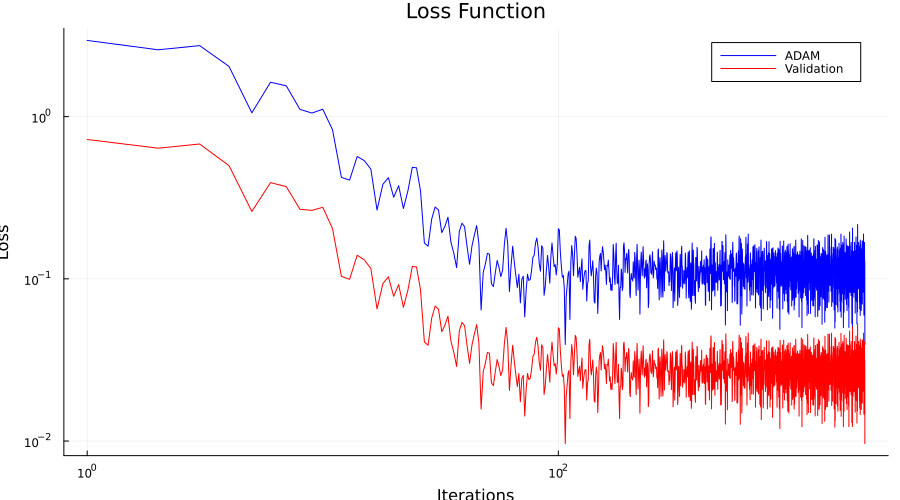

In [19]:
# Plot losses

default(size = (900, 500));
plot(
    1:loss_adam_end, losses[1:loss_adam_end], 
    yaxis = :log10, xaxis = :log10, 
    label = "ADAM", color = :blue,
    title = "Loss Function"
);

plot!(
    1:lossval_adam_end, val_losses[1:lossval_adam_end], 
    yaxis = :log10, xaxis = :log10, 
    label = "Validation", color = :red,
    title = "Loss Function"
);

xlabel!("Iterations")
ylabel!("Loss")

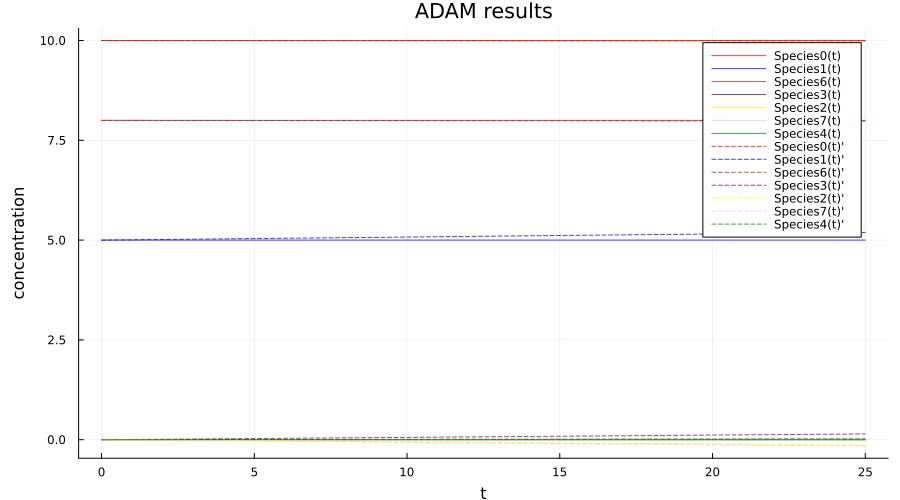

In [20]:
# Plot the trained model
tp = res1.minimizer;
X3 = Array(FWmodule.predict(tp, prob_nn, method, abstol, reltol, saveat));

default(size = (900, 500))
plot(
    t, 
    X'[:, selected_species],
    title = "ADAM results",
    alpha=0.75, 
    labels=permutedims(speciesvector),
    ls=permutedims([:solid,:solid,:solid,:solid,:solid,:solid,:solid,:solid,:solid,:solid]),
    color=permutedims([:red, :blue, :brown, :purple, :yellow, :pink, :green, :orange, :grey, :black])
)

xlabel!("t")
ylabel!("concentration")
speciesvector2_ = [string(s)*"'" for s in speciesvector2]
plot!(
    t, 
    X3',
    alpha=0.75,
    labels=permutedims(speciesvector2_),
    ls=:dash,
    color=permutedims([:red, :blue, :brown, :purple, :yellow, :pink, :green, :orange, :grey, :black]),
    left_margin=5Plots.mm
)